In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.colors import to_rgba
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data_path = 'BudgetAnalysisOverADecade.csv'
df = pd.read_csv(data_path)

In [24]:
df.head()

,Department,Ministry,2015-2016 Revenue,2015-2016 Capital,2015-2016 Total,2016-2017 Revenue,2016-2017 Capital,2016-2017 Total,2017-2018 Revenue,2017-2018 Capital,...,2021-2022 Total,2022-2023 Revenue,2022-2023 Capital,2022-2023 Total,2023-2024 Revenue,2023-2024 Capital,2023-2024 Total,2024-2025 Revenue,2024-2025 Capital,2024-2025 Total
0,Department of Agriculture and Farmers Welfare,Ministry of Agriculture and Farmers Welfare,16959.36,44.99,17004.35,35952.83,30.86,35983.69,41775.57,79.43,...,123017.57,123960.75,39.25,124000.00,115489.37,42.42,115531.79,122433.13,95.64,122528.77
1,Department of Agricultural Research and Education,Ministry of Agriculture and Farmers Welfare,6320.00,0.00,6320.00,6620.00,0.00,6620.00,6800.00,0.00,...,8513.62,8513.62,0.00,8513.62,9493.59,10.41,9504.00,9934.59,6.50,9941.09
2,Atomic Energy,Department of Atomic Energy,4839.31,4360.69,9200.00,5794.03,5888.45,11682.48,7264.02,5197.18,...,18264.89,8440.34,14283.24,22723.58,9096.99,15981.50,25078.49,11108.19,13860.79,24968.98
3,Ministry of Ayush,Ministry of AYUSH,1197.00,17.00,1214.00,1323.20,3.00,1326.20,1425.35,3.30,...,2970.30,3050.00,0.00,3050.00,3641.56,5.94,3647.50,3703.74,8.75,3712.49
4,Department of Chemicals and Petrochemicals,Ministry of Chemicals and Fertilisers,223.15,32.03,255.18,162.01,40.03,202.04,273.39,24.61,...,233.14,207.67,1.33,209.00,172.55,0.90,173.45,136.82,122.29,259.11


Q1. How have total allocations (Revenue + Capital) evolved for each department over the last decade? Which sectors have shown the fastest growth (CAGR)?

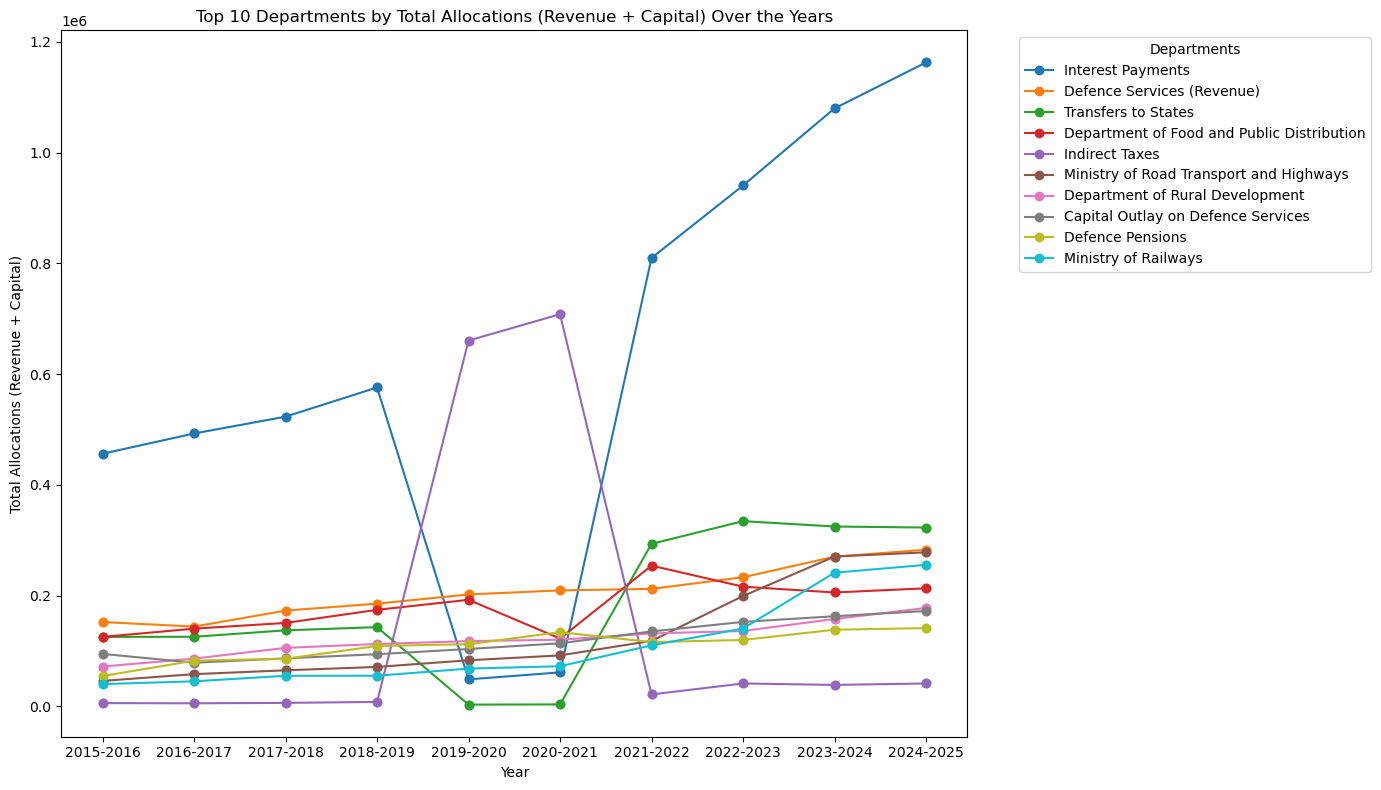

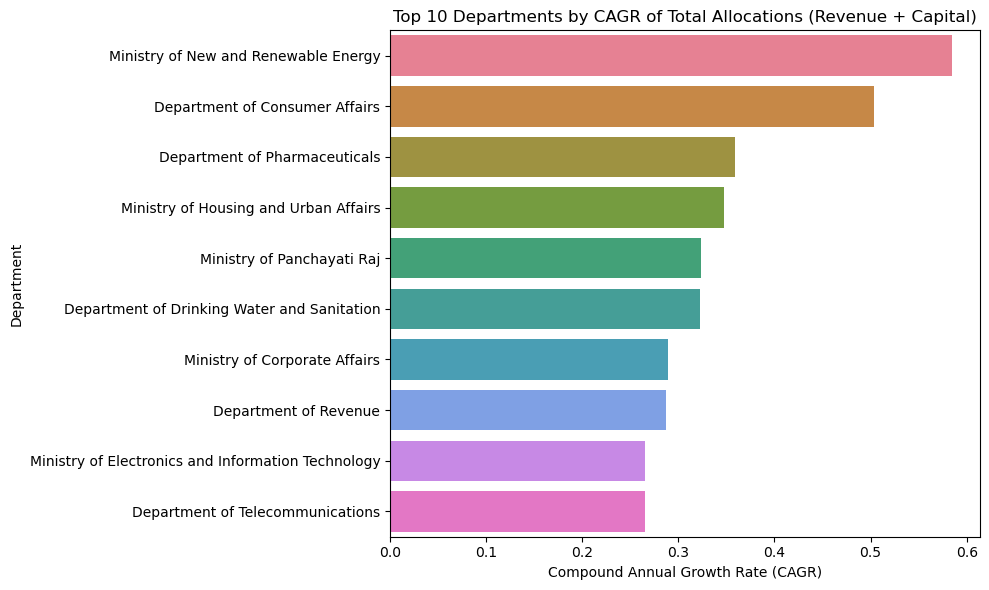

In [5]:
df_long = pd.melt(df, id_vars=['Department'], 
                  value_vars=[col for col in df.columns if 'Revenue' in col or 'Capital' in col], 
                  var_name='Year', value_name='Amount')

df_long['Year'] = df_long['Year'].str.split().str[0]  
df_long['Allocation_Type'] = df_long['Year'].str.split().str[1]  

df_long = df_long[df_long['Allocation_Type'] != 'Total']

df_long['Total_Allocations'] = df_long.groupby(['Department', 'Year'])['Amount'].transform('sum')

def calculate_cagr(start_value, end_value, years):
    if start_value == 0 or end_value == 0:
        return np.nan 
    return (end_value/start_value)**(1/years) - 1

years_range = sorted(df_long['Year'].unique())
years = len(years_range) - 1

cagr_data_list = []

for department in df_long['Department'].unique():
    department_data = df_long[df_long['Department'] == department]
    start_value = department_data[department_data['Year'] == years_range[0]]['Total_Allocations'].values[0]
    end_value = department_data[department_data['Year'] == years_range[-1]]['Total_Allocations'].values[0]
    cagr = calculate_cagr(start_value, end_value, years)
    cagr_data_list.append({"Department": department, "CAGR": cagr})

cagr_data = pd.DataFrame(cagr_data_list)

total_allocations_by_dept = df_long.groupby('Department')['Total_Allocations'].sum().sort_values(ascending=False).head(10)

top_10_by_total = df_long[df_long['Department'].isin(total_allocations_by_dept.index)]

plt.figure(figsize=(14, 8))
for department in total_allocations_by_dept.index:
    department_data = top_10_by_total[top_10_by_total['Department'] == department]
    plt.plot(department_data['Year'], department_data['Total_Allocations'], label=department, marker='o')

plt.xlabel('Year')
plt.ylabel('Total Allocations (Revenue + Capital)')
plt.title('Top 10 Departments by Total Allocations (Revenue + Capital) Over the Years')
plt.legend(title="Departments", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

top_cagr_data = cagr_data.sort_values(by='CAGR', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_cagr_data, x='CAGR', y='Department', palette='husl')
plt.xlabel('Compound Annual Growth Rate (CAGR)')
plt.ylabel('Department')
plt.title('Top 10 Departments by CAGR of Total Allocations (Revenue + Capital)')

plt.tight_layout()
plt.show()


Q2. Which departments consistently receive the largest share of the total budget, and how has the balance between Revenue and Capital expenditure shifted across these departments over the years?

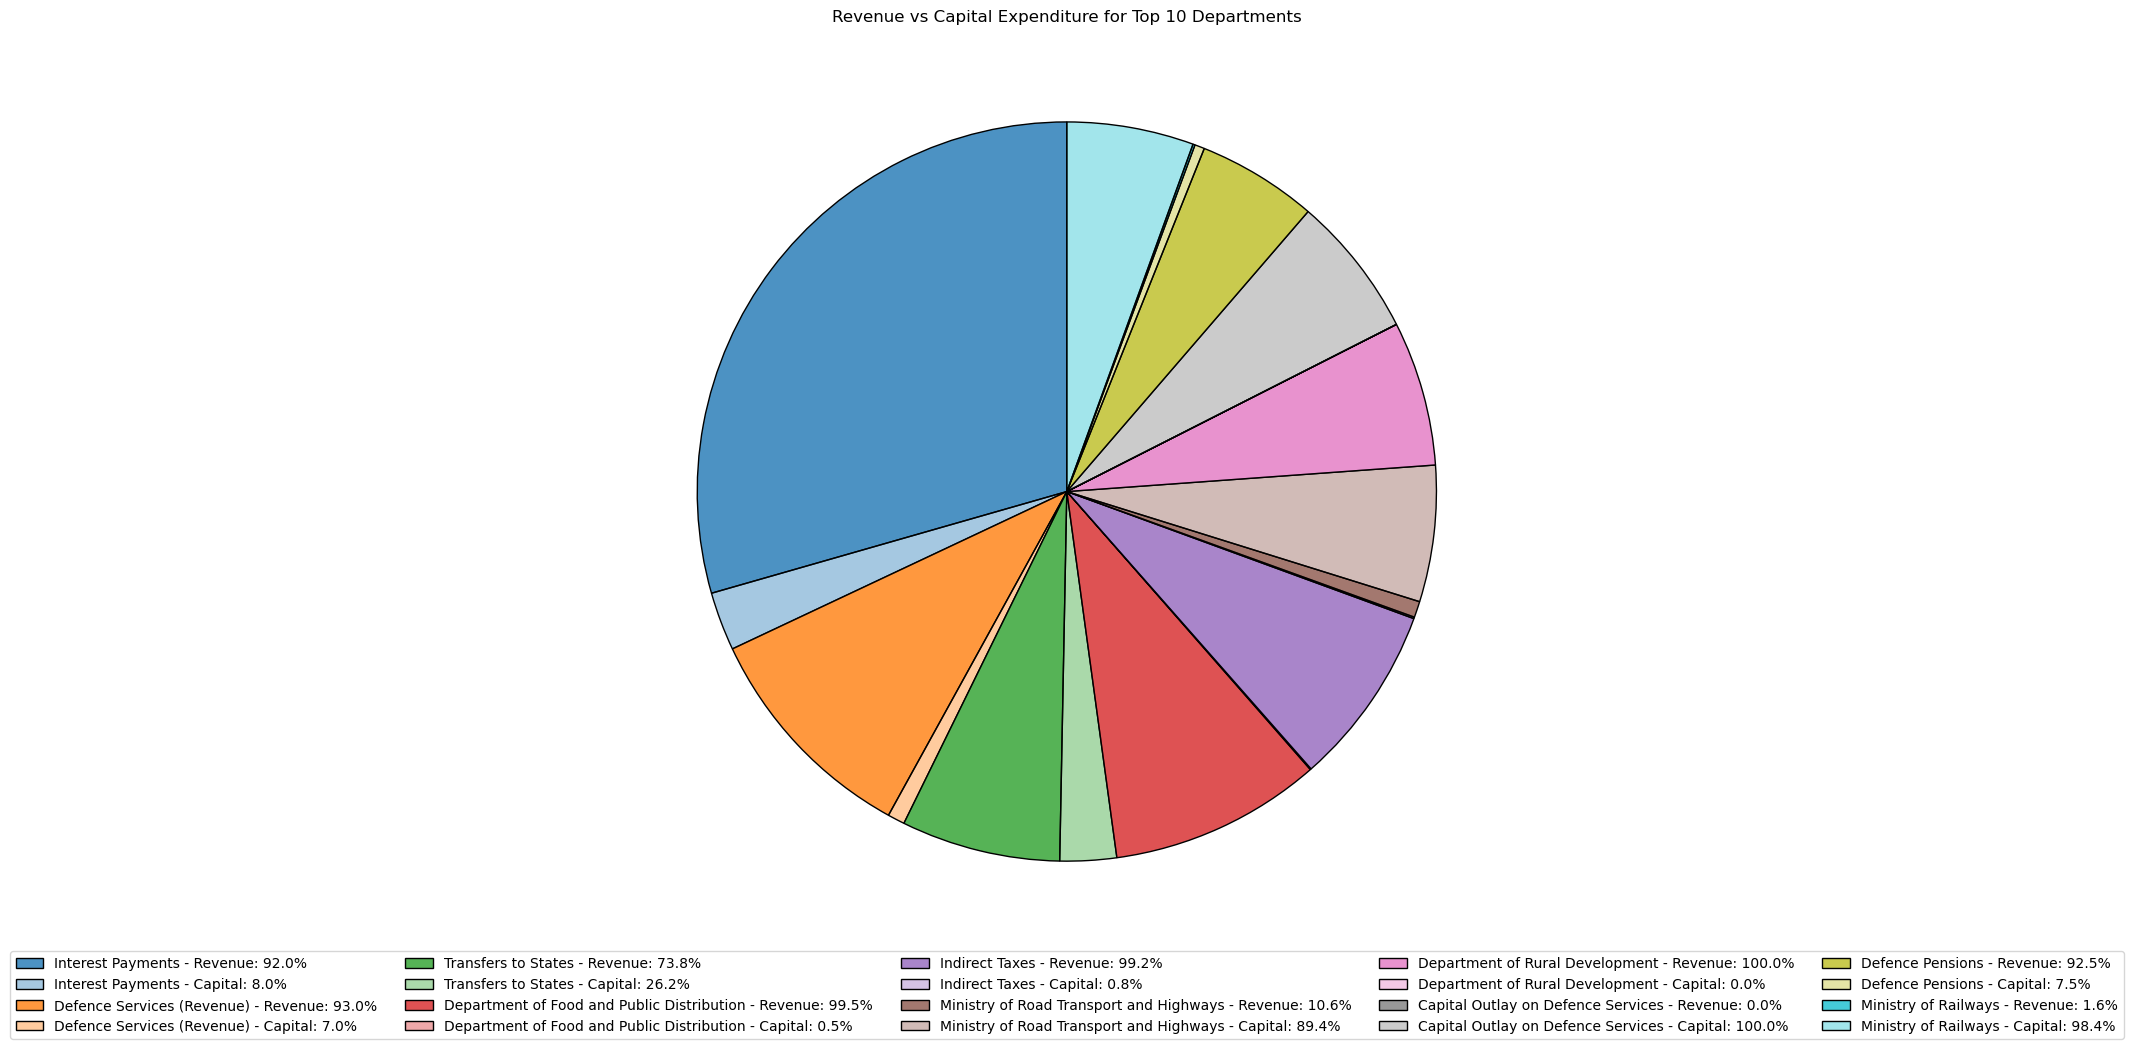

In [11]:
revenue_columns = [col for col in df.columns if 'Revenue' in col]
capital_columns = [col for col in df.columns if 'Capital' in col]

df['Total_Revenue'] = df[revenue_columns].sum(axis=1)
df['Total_Capital'] = df[capital_columns].sum(axis=1)

df['Total_Allocations'] = df['Total_Revenue'] + df['Total_Capital']

top_10_by_total = df[['Department', 'Total_Allocations']].sort_values(by='Total_Allocations', ascending=False).head(10)
df_top_10 = df[df['Department'].isin(top_10_by_total['Department'])]

department_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
]

sizes = []
labels = []
colors = []
startangle = 90
legend_labels = []

for i, department in enumerate(top_10_by_total['Department']):
    department_data = df_top_10[df_top_10['Department'] == department]
    
    total_revenue = department_data['Total_Revenue'].values[0]
    total_capital = department_data['Total_Capital'].values[0]
    
    sizes.append(total_revenue)
    sizes.append(total_capital)
    
    labels.append(f"Revenue - {department}")
    labels.append(f"Capital - {department}")
    
    revenue_color = to_rgba(department_colors[i], alpha=0.8)
    capital_color = to_rgba(department_colors[i], alpha=0.4)
    
    colors.append(revenue_color)
    colors.append(capital_color)

    # Add label with department and percentage to the legend
    total_allocation = total_revenue + total_capital
    revenue_percentage = (total_revenue / total_allocation) * 100
    capital_percentage = (total_capital / total_allocation) * 100
    legend_labels.append(f"{department} - Revenue: {revenue_percentage:.1f}%")
    legend_labels.append(f"{department} - Capital: {capital_percentage:.1f}%")

plt.figure(figsize=(12, 12))
plt.pie(sizes, labels=None, colors=colors, startangle=startangle, wedgeprops={'edgecolor': 'black'})

plt.title('Revenue vs Capital Expenditure for Top 10 Departments')

# Add detailed legend below the chart
plt.legend(legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=5)

plt.tight_layout()
plt.show()

Q3. What percentage of each department’s budget is allocated to Capital expenditure versus Revenue, and has there been a noticeable shift towards infrastructure-oriented spending over time?

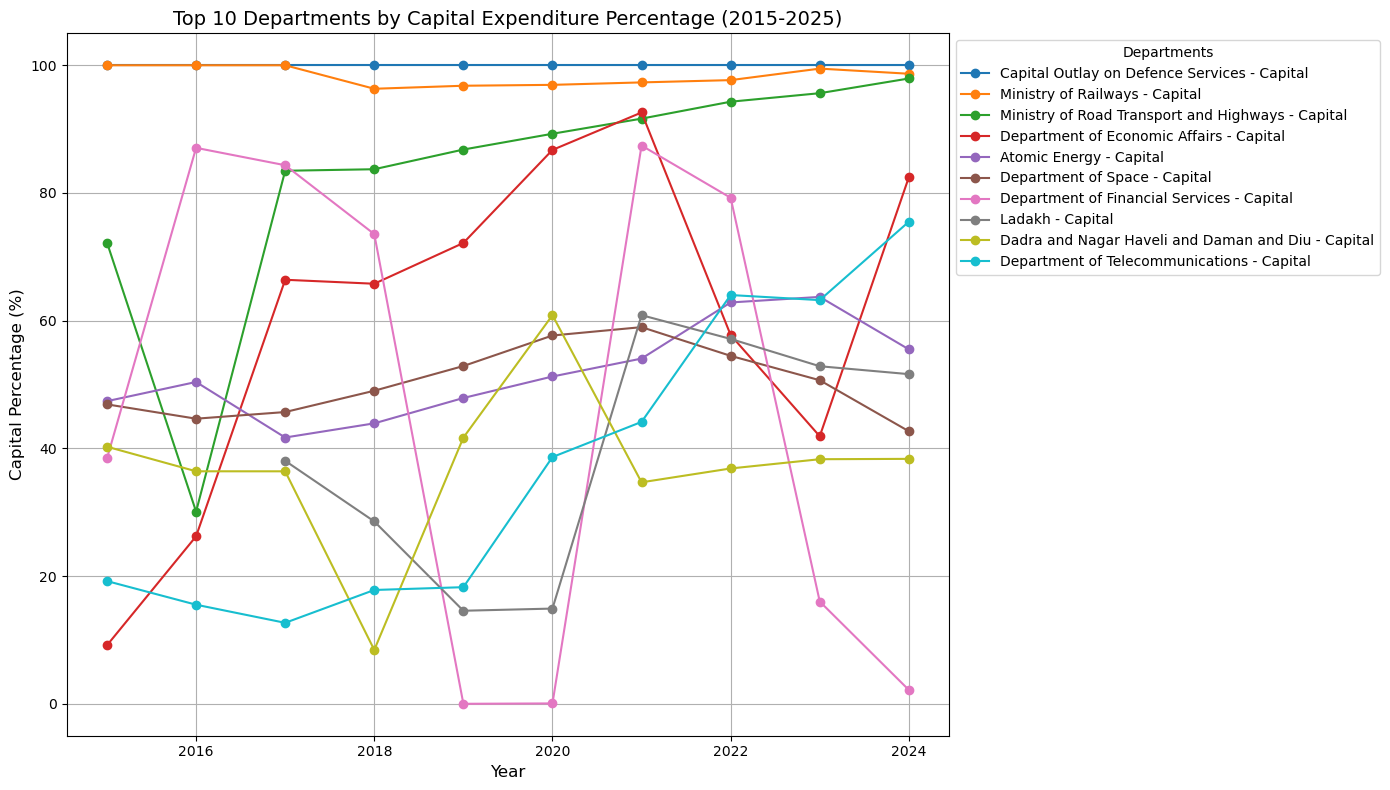

In [9]:
capital_columns = [col for col in df.columns if 'Capital' in col]

for year in range(2015, 2025):
    capital_col = f'{year}-{year+1} Capital'
    df[f'{year}-{year+1} Capital Percentage'] = df[capital_col] / (df[capital_col] + df[f'{year}-{year+1} Revenue']) * 100

df['Avg_Capital_Percentage'] = df[[f'{year}-{year+1} Capital Percentage' for year in range(2015, 2025)]].mean(axis=1)

top_10_departments = df.sort_values('Avg_Capital_Percentage', ascending=False).head(10)

plt.figure(figsize=(14, 8))

for index, row in top_10_departments.iterrows():
    years = range(2015, 2025)
    capital_percentage = [row[f'{year}-{year+1} Capital Percentage'] for year in years]
    plt.plot(years, capital_percentage, label=f"{row['Department']} - Capital", linestyle='-', marker='o')

plt.title('Top 10 Departments by Capital Expenditure Percentage (2015-2025)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Capital Percentage (%)', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Departments')
plt.grid(True)
plt.tight_layout()
plt.show()


Q4. At an aggregate level, is there a measurable increase in Capital Expenditure’s share of the total Union Budget over the last 10 years? Which sectors have contributed most to this shift?

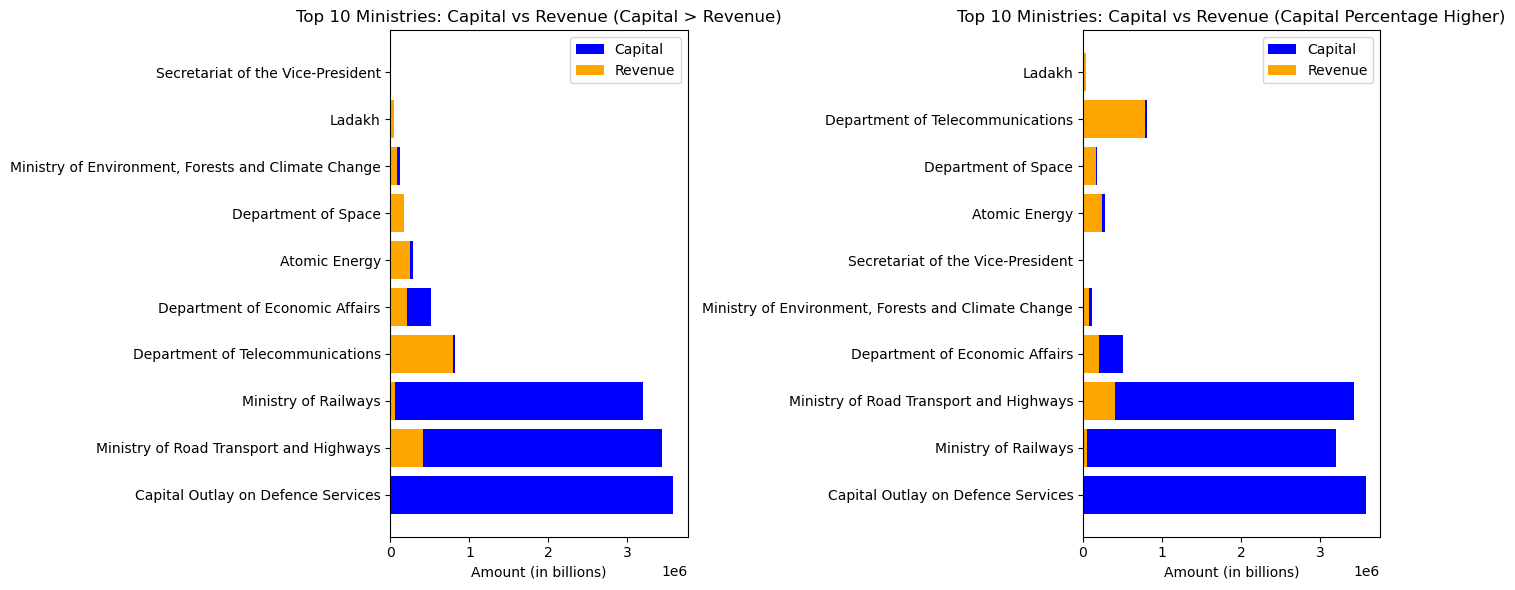

In [10]:
capital_columns = [col for col in df.columns if 'Capital' in col]
revenue_columns = [col for col in df.columns if 'Revenue' in col]

df['Total_Capital'] = df[capital_columns].sum(axis=1)
df['Total_Revenue'] = df[revenue_columns].sum(axis=1)

filtered_capital_more_than_revenue = df[df['Total_Capital'] > df['Total_Revenue']]
top_10_capital_more_than_revenue = filtered_capital_more_than_revenue.sort_values('Total_Capital', ascending=False).head(10)

df['Capital_Percentage'] = df['Total_Capital'] / (df['Total_Capital'] + df['Total_Revenue']) * 100
filtered_capital_percentage_higher = df[df['Total_Capital'] > df['Total_Revenue']]
top_10_capital_percentage_higher = filtered_capital_percentage_higher.sort_values('Capital_Percentage', ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].barh(top_10_capital_more_than_revenue['Department'], top_10_capital_more_than_revenue['Total_Capital'], color='blue', label='Capital')
axes[0].barh(top_10_capital_more_than_revenue['Department'], top_10_capital_more_than_revenue['Total_Revenue'], color='orange', label='Revenue')
axes[0].set_title('Top 10 Ministries: Capital vs Revenue (Capital > Revenue)')
axes[0].set_xlabel('Amount (in billions)')
axes[0].legend()

axes[1].barh(top_10_capital_percentage_higher['Department'], top_10_capital_percentage_higher['Total_Capital'], color='blue', label='Capital')
axes[1].barh(top_10_capital_percentage_higher['Department'], top_10_capital_percentage_higher['Total_Revenue'], color='orange', label='Revenue')
axes[1].set_title('Top 10 Ministries: Capital vs Revenue (Capital Percentage Higher)')
axes[1].set_xlabel('Amount (in billions)')
axes[1].legend()

plt.tight_layout()
plt.show()


Q5. Can we identify trends in the budget allocation across ministries, and forecast the likely direction of future allocations based on past trends?

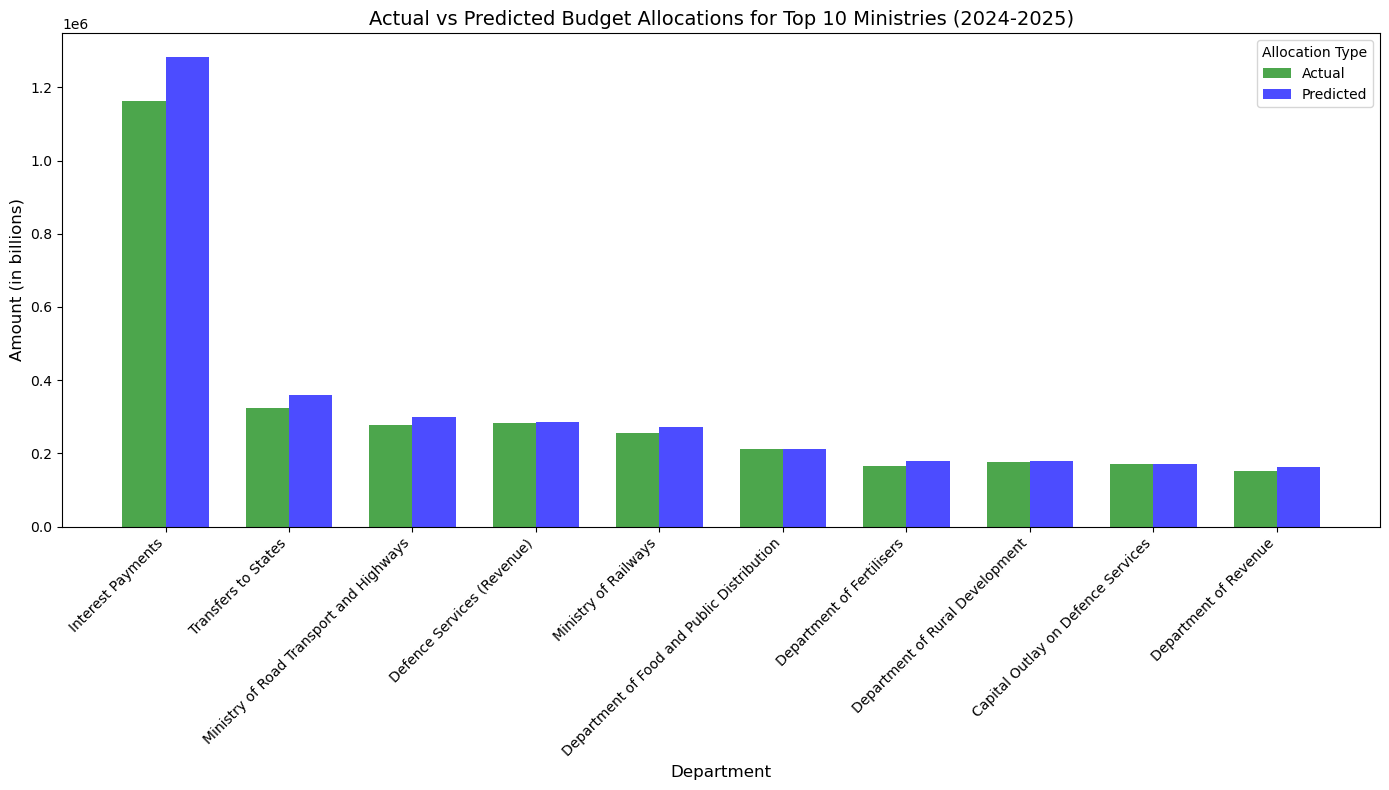

In [13]:
years = range(2015, 2025)
total_columns = [f'{year}-{year+1} Total' for year in years]

X = np.array(years).reshape(-1, 1)
plot_data = []
predictions = []
actual_values = []

for index, row in df.iterrows():
    y = row[total_columns].values
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    predicted_2024_2025 = model.predict(poly.transform(np.array([[2024]])))[0]
    actual_2024_2025 = row['2024-2025 Total']
    predictions.append(predicted_2024_2025)
    actual_values.append(actual_2024_2025)
    plot_data.append({
        'Department': row['Department'],
        'Predicted': predicted_2024_2025,
        'Actual': actual_2024_2025
    })

plot_df = pd.DataFrame(plot_data)
top_10_departments = plot_df.sort_values('Predicted', ascending=False).head(10)

plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(top_10_departments))
plt.bar(index, top_10_departments['Actual'], bar_width, color='green', alpha=0.7, label='Actual')
plt.bar(index + bar_width, top_10_departments['Predicted'], bar_width, color='blue', alpha=0.7, label='Predicted')
plt.title('Actual vs Predicted Budget Allocations for Top 10 Ministries (2024-2025)', fontsize=14)
plt.xlabel('Department', fontsize=12)
plt.ylabel('Amount (in billions)', fontsize=12)
plt.xticks(index + bar_width / 2, top_10_departments['Department'], rotation=45, ha="right")
plt.legend(title='Allocation Type')
plt.tight_layout()
plt.show()
